In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tight_binding.bandstructure import compute_eigenstates
from tight_binding.topology import gauge_fix_path
from tight_binding.hamiltonians import kagome_hamiltonian_static

In [2]:
H = kagome_hamiltonian_static(0,0,0,1,1)

In [13]:
path = np.linspace(0,1,100)
kx = path * 3
ky = np.ones(100) * 0
energies = np.zeros((100,3))
blochvectors = np.zeros((100,3,3))

In [14]:
for i in range(len(path)):
    k = np.array([kx[i], ky[i]])
    energy, blochvector = compute_eigenstates(H,k,regime='static')
    energies[i] = energy
    blochvectors[i] = blochvector

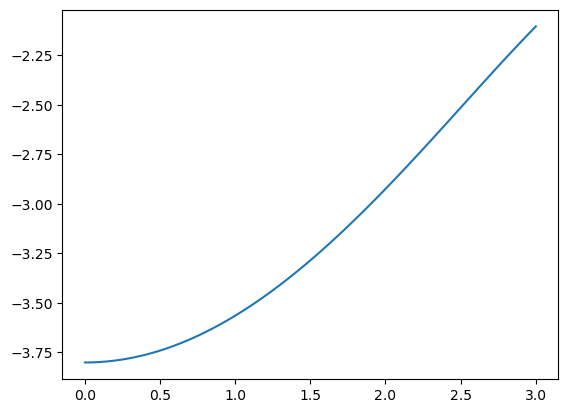

In [5]:
# Plotting band 0
plt.plot(kx,energies[:,0])
plt.show()

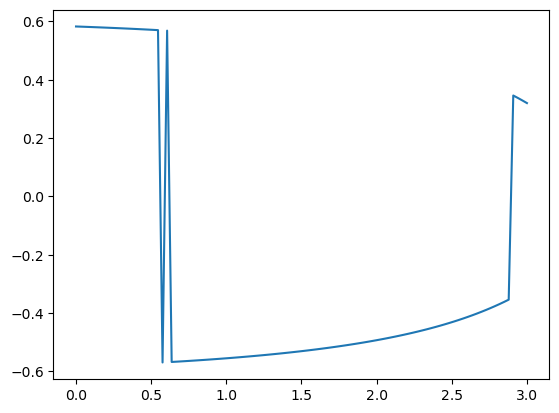

In [6]:
# Plotting the 0 component of the blochvectors in band 0
plt.plot(kx,blochvectors[:,0,0])
plt.show()

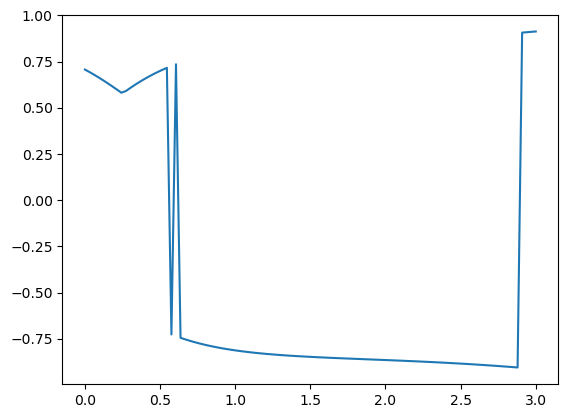

In [7]:
# Plotting the 0 component of the blochvectors in band 1
plt.plot(kx,blochvectors[:,0,1])
plt.show()

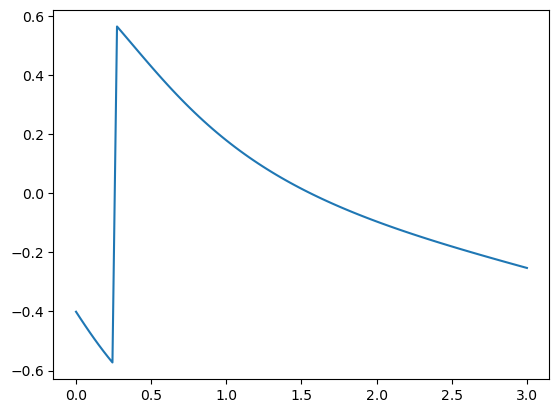

In [8]:
# Plotting the 0 component of the blochvectors in band 2
plt.plot(kx,blochvectors[:,0,2])
plt.show()

In [9]:
# Gauge fixing
blochvectors = gauge_fix_path(blochvectors)

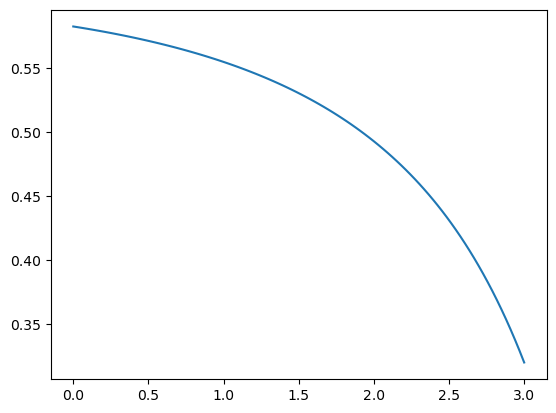

In [10]:
# Plotting the 0 component of the blochvectors in band 0
plt.plot(kx,blochvectors[:,0,0])
plt.show()

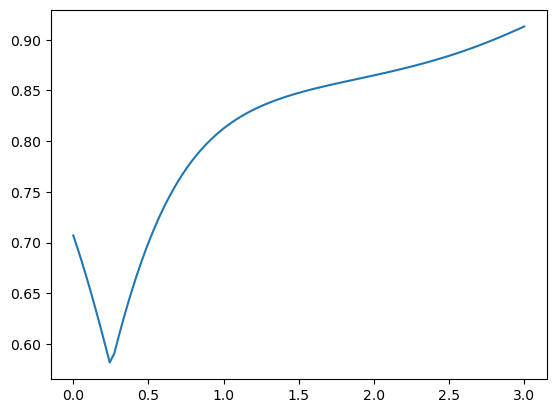

In [11]:
# Plotting the 0 component of the blochvectors in band 1
plt.plot(kx,blochvectors[:,0,1])
plt.show()

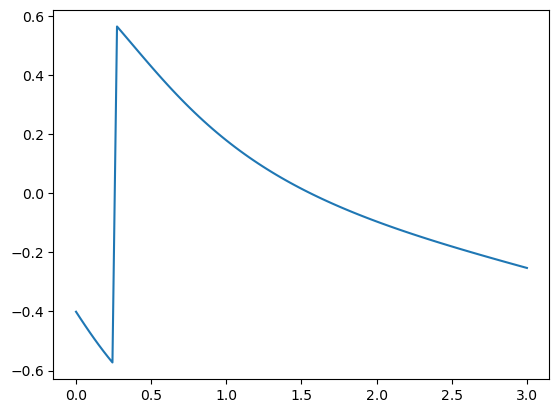

In [12]:
# Plotting the 0 component of the blochvectors in band 2
plt.plot(kx,blochvectors[:,0,2])
plt.show()